# RNN으로 스팸메일 분류하기

- dataset: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [ ]:
from nltk.tokenize import TreebankWordTokenizer

class Vocabulary:

    def __init__(self, dataset, min_freq):
        self.itos = {0: '<PAD>', 1: '<UNK>'}
        self.stoi = {k:j for j,k in self.itos.items()}
        self.dataset = dataset
        self.min_freq = min_freq
        self.build_vocabulary()

    def __len__(self):
        return len(self.itos)

    def tokenize(self, text):
        tokenizer = TreebankWordTokenizer()
        return tokenizer.tokenize(text.strip().lower())

    def build_vocabulary(self):
        from collections import defaultdict
        voca_dict = defaultdict(int)
        voca_list = []
        for data in self.dataset:
            for word in self.tokenize(data):
                voca_dict[word] += 1

        for k, v in voca_dict.items():
            if v >= self.min_freq:
                voca_list.append(k)

        for i, voca in enumerate(voca_list):
            self.itos[i+2] = voca
            self.stoi[voca] = i+2

    def word2num(self, tokenized_text):
        word2num_text = []
        for token in tokenized_text:
            if token in self.stoi:
                word2num_text.append(self.stoi[token])
            else:
                word2num_text.append(self.stoi['<UNK>'])

        return word2num_text

## Load and split dataset

In [ ]:
import pandas as pd

# ===== Load dataset =====
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df.loc[:, ['v1', 'v2']]
df.dropna(inplace=True)
df['v1'] = df['v1'].replace(['ham','spam'],[0,1])
df.drop_duplicates(inplace=True)

X = df['v2'].to_list()
Y = df['v1'].to_list()

In [ ]:
# ===== bulid vocabulary =====
vocab = Vocabulary(X, min_freq=3)

In [ ]:
seq_lens = []
for x in X:
    seq_lens.append(len(x))

max_len = sum(seq_lens)//len(X)
print(max_len)

78


In [ ]:
# ===== Split dataset =====
# train : test = 0.7: 0.3
train_idx = int(len(X)*0.7)
train_x, train_y = X[:train_idx], Y[:train_idx]
test_x, test_y = X[train_idx:], Y[train_idx:]

print(f"train - total: {len(train_x)}개, ham: {train_y.count(0)}개, spam: {train_y.count(1)}개")
print(f"test - total: {len(test_x)}개, ham: {test_y.count(0)}개, spam: {test_y.count(1)}개")

train - total: 3618개, ham: 3154개, spam: 464개
test - total: 1551개, ham: 1362개, spam: 189개


## Custom Dataset

In [ ]:
import torch.utils.data as data

class SmsDataset(data.Dataset):
    def __init__(self, text, label, vocab, max_len):
        super(SmsDataset, self).__init__()

        self.text = text
        self.label = label
        self.vocab = vocab
        self.max_len = max_len

    def __getitem__(self, idx):
        tmp_text = self.vocab.tokenize(self.text[idx])
        if len(tmp_text) > self.max_len:
            tmp_text = tmp_text[:self.max_len]
        else:
            tmp_text = tmp_text + ["<PAD>"]*(self.max_len - len(tmp_text))

        return {'text': torch.Tensor(self.vocab.word2num(tmp_text)).to(torch.int32), 'label': self.label[idx]}

    def __len__(self):
        return len(self.text)

In [ ]:
train_set = SmsDataset(train_x, train_y, vocab, max_len=max_len)
test_set = SmsDataset(test_x, test_y, vocab, max_len=max_len)

## Model Define

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, batch_size, embedding_size, hidden_size, output_size, vocab_size, n_layers):
        super(RNN, self).__init__()

        self.batch_size = batch_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.rnn = nn.RNN(input_size=embedding_size,
                          hidden_size=hidden_size,
                          num_layers=n_layers,
                          batch_first=True,
                          bias=False) # tanh(W_x*x_t + W_h*h_t-1)
        self.fc = nn.Linear(hidden_size, output_size, bias = False) # W_y*h_t
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        output, h_n = self.rnn(x)
        output = self.softmax(self.fc(output[:, -1, :]))

        return output

## Train

In [ ]:
def train(model, loss_fn, optimizer, train_loader):
    model.train()

    cur_loss = 0

    for i, data in enumerate(train_loader):
        model.zero_grad()
        optimizer.zero_grad()

        texts = data['text']
        y_true = data['label']

        outputs = model(texts)

        loss = loss_fn(outputs, y_true)
        loss.backward()
        optimizer.step()
        cur_loss += loss.item()

    return outputs, cur_loss/(len(train_loader))

In [ ]:
epochs = 100
learning_rate = 0.001
batch_size = 64
embedding_size = 32
hidden_size = 32
num_class = 2
n_layers = 2

In [ ]:
import torch.optim as optim

model = RNN(batch_size, embedding_size, hidden_size, num_class, len(vocab), n_layers)

loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = data.DataLoader(train_set, batch_size, shuffle=True, drop_last=True)

all_losses = []

for i in range(1, epochs+1):
    output, loss = train(model, loss_fn, optimizer, train_loader)
    all_losses.append(loss)

    if i%5==0:
        print(f"epoch {i} - loss: {loss}")

epoch 5 - loss: 0.4665969046098845
epoch 10 - loss: 0.4599743168801069
epoch 15 - loss: 0.46881108624594553
epoch 20 - loss: 0.47833204322627615
epoch 25 - loss: 0.4702507693852697
epoch 30 - loss: 0.5080083800213677
epoch 35 - loss: 0.4597058727272919
epoch 40 - loss: 0.4477932479764734
epoch 45 - loss: 0.44426523947290014
epoch 50 - loss: 0.45393451516117367
epoch 55 - loss: 0.4173325773860727
epoch 60 - loss: 0.42223076256258146
epoch 65 - loss: 0.42234617844223976
epoch 70 - loss: 0.4485575349203178
epoch 75 - loss: 0.4247156142124108
epoch 80 - loss: 0.4265984169074467
epoch 85 - loss: 0.4276671218020575
epoch 90 - loss: 0.42798067230199066
epoch 95 - loss: 0.4280381681663649
epoch 100 - loss: 0.4274824447929859


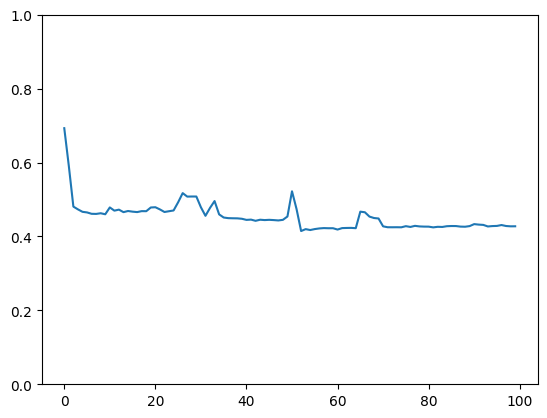

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.ylim([0, 1.0])
plt.plot(all_losses)

## Evaluate

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def evaluate(model, test_loader):
    model.eval()
    f1, acc = 0, 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            texts = data['text']
            y_true = data['label']
            output = model(texts)

            _, y_pred = torch.max(output, 1)

            f1 += f1_score(y_true, y_pred)
            acc += accuracy_score(y_true, y_pred)

    return f1/len(test_loader), acc/len(test_loader)

In [ ]:
test_loader = data.DataLoader(test_set, batch_size, shuffle=True, drop_last=True)

f1, acc = evaluate(model, test_loader)
print(f1, acc)

0.2825329082682024 0.8411458333333334
